# Latent Vector Clustering

1. 학습한 모델에서 나온 128차원 벡터를 클러스터링할 것이다.
2. 같은 클러스터끼리 동일한 색으로 표시하여 2차원에 나타낼 것이다.
3. 클러스터별 글자 모양을 확인할 것이다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/')

In [0]:
import numpy as np
import os
import io
import csv
from common.dataset import PickledImageProvider
from common.dataset import KoreanFontDataset
from common.utils import pad_seq, bytes_to_file, \
    read_split_image, shift_and_resize_image, normalize_image, \
    tight_crop_image, add_padding

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from PIL import Image
import os
import os.path

import torch.utils.data
import torchvision.transforms as transforms

def default_image_loader(path):
    return Image.open(path).convert('RGB')

class TripletImageLoader(torch.utils.data.Dataset): 
    def __init__(self, pickled, triplets_file_name, base_path=None, filenames_filename=None, transform=None,
                 loader=default_image_loader):
        """ 
        filenames_filename: 
            A text file with each line containing the path to an image e.g.,
            images/class1/sample.jpg
                
        triplets_file_name: 
            A text file with each line containing three integers, 
            where integer i refers to the i-th image in the filenames file. 
            For a line of intergers 'a b c', a triplet is defined such that image a is more 
            similar to image c than it is to image b, 
            e.g., 0 2017 42 
        """
        self.dset = pickled.examples
#         self.base_path = base_path  
#         self.filenamelist = []
#         for line in open(filenames_filename):
#             self.filenamelist.append(line.rstrip('\n'))
        triplets = []
        anchor_labels = [] #
        for line in open(triplets_file_name):
            triplets.append((line.split()[0], line.split()[1], line.split()[2])) # anchor, far, close
            anchor_labels.append(int(line.split()[3])) #
        self.triplets = triplets
        self.labels = anchor_labels #
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path1, path2, path3 = self.triplets[index]
        anchor_label = self.labels[index]
        img1_tuple = self.dset[int(path1)]
        img2_tuple = self.dset[int(path2)]
        img3_tuple = self.dset[int(path3)]
        
        info = {                         # clustering을 위해 anchor_index도 추가하였다.
            'anchor_index': int(path1),
            'anchor_label': anchor_label
        }
        
        # byte만 사용할 예정
        img1, byte_1 = img1_tuple[0], img1_tuple[1]
        img2, byte_2 = img2_tuple[0], img2_tuple[1]
        img3, byte_3 = img3_tuple[0], img3_tuple[1]
        
        # bytes 타입을 numpy array로 변경 후 normalize
        img_arr_1 = np.array(Image.open(io.BytesIO(byte_1)))
        img_arr_1 = normalize_image(img_arr_1)
        
        img_arr_2 = np.array(Image.open(io.BytesIO(byte_2)))
        img_arr_2 = normalize_image(img_arr_2)
        
        img_arr_3 = np.array(Image.open(io.BytesIO(byte_3)))
        img_arr_3 = normalize_image(img_arr_3)

        cropped_image_1, cropped_image_size_1 = tight_crop_image(img_arr_1, verbose=False)
        centered_image_1 = add_padding(cropped_image_1, verbose=False)
        
        cropped_image_2, cropped_image_size_2 = tight_crop_image(img_arr_2, verbose=False)
        centered_image_2 = add_padding(cropped_image_2, verbose=False)
        
        cropped_image_3, cropped_image_size_3 = tight_crop_image(img_arr_3, verbose=False)
        centered_image_3 = add_padding(cropped_image_3, verbose=False)
            
        return (centered_image_1, centered_image_2, centered_image_3), info #

    def __len__(self):
        return len(self.triplets)

In [5]:
pickled = PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj')
triplet_loader = TripletImageLoader(pickled, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/triplet_list_with_label.txt')

processed 10000 examples
processed 20000 examples
processed 30000 examples
processed 40000 examples
processed 50000 examples
processed 60000 examples
processed 70000 examples
processed 80000 examples
processed 90000 examples
processed 100000 examples
processed 110000 examples
processed 120000 examples
processed 130000 examples
processed 140000 examples
processed 150000 examples
processed 160000 examples
processed 170000 examples
processed 180000 examples
processed 190000 examples
processed 200000 examples
processed 210000 examples
processed 220000 examples
processed 230000 examples
processed 240000 examples
processed 250000 examples
processed 260000 examples
processed 270000 examples
processed 280000 examples
processed 290000 examples
processed 300000 examples
processed 310000 examples
processed 320000 examples
processed 330000 examples
processed 340000 examples
processed 350000 examples
processed 360000 examples
processed 370000 examples
processed 380000 examples
processed 390000 exam

In [6]:
len(triplet_loader[1][0]) # anchor, negative, positive images

3

In [7]:
triplet_loader[1][1] # anchor label == 0 ( ~ triplet_loader[2349][1])

{'anchor_index': 1776, 'anchor_label': 0}

### 전체 데이터셋 준비

In [8]:
dset = KoreanFontDataset(PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj'), vector_size=10)

processed 10000 examples
processed 20000 examples
processed 30000 examples
processed 40000 examples
processed 50000 examples
processed 60000 examples
processed 70000 examples
processed 80000 examples
processed 90000 examples
processed 100000 examples
processed 110000 examples
processed 120000 examples
processed 130000 examples
processed 140000 examples
processed 150000 examples
processed 160000 examples
processed 170000 examples
processed 180000 examples
processed 190000 examples
processed 200000 examples
processed 210000 examples
processed 220000 examples
processed 230000 examples
processed 240000 examples
processed 250000 examples
processed 260000 examples
processed 270000 examples
processed 280000 examples
processed 290000 examples
processed 300000 examples
processed 310000 examples
processed 320000 examples
processed 330000 examples
processed 340000 examples
processed 350000 examples
processed 360000 examples
processed 370000 examples
processed 380000 examples
processed 390000 exam

In [9]:
len(dset)

251450

In [10]:
dset[0] # 주의) 여기서의 font_index와 TripletLoader의 anchor_label은 다르다.

({'font_doc2vec': [2.2403063999999997,
   -1.4756056999999998,
   -0.593018,
   -0.18605323,
   -1.2381212,
   -1.161201,
   2.8255024,
   0.10454782,
   -0.16260550000000001,
   1.2440913999999998],
  'font_index': 0,
  'word_index': 0},
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [11]:
dset[1776] # anchor index 1776의 실제 img

({'font_doc2vec': [2.2403063999999997,
   -1.4756056999999998,
   -0.593018,
   -0.18605323,
   -1.2381212,
   -1.161201,
   2.8255024,
   0.10454782,
   -0.16260550000000001,
   1.2440913999999998],
  'font_index': 0,
  'word_index': 482},
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

---
## Load Trained Model

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import shutil
import os
import io

class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z

In [0]:
# FontStyler의 convAE 코드 (layers.py)
class Encoder_conv(nn.Module):
    
    def __init__(self, img_dim=1, conv_dim=16): # output dim은 128이 될 것
        super(Encoder_conv, self).__init__()
        self.conv1 = conv2d(img_dim, conv_dim, k_size=5, stride=2, pad=2, dilation=2, lrelu=False, bn=False)
        self.conv2 = conv2d(conv_dim, conv_dim*2, k_size=5, stride=4, pad=2, dilation=2)
        self.conv3 = conv2d(conv_dim*2, conv_dim*4, k_size=4, stride=4, pad=1, dilation=1)
        self.conv4 = conv2d(conv_dim*4, conv_dim*8)
        self.conv5 = conv2d(conv_dim*8, conv_dim*8)
    
    def forward(self, images):
        # |images| = (batch, img, img)
        # print(images.shape)
        images = images.unsqueeze(dim=1)
        # |images| = (batch, 1, 128, 128)
        # print(images.shape)
        e1 = self.conv1(images)
        # |e1| = (batch, conv_dim, 64, 64)
        # print(e1.shape)
        e2 = self.conv2(e1)
        # |e2| = (batch, conv_dim*2, 16, 16)
        # print(e2.shape)
        e3 = self.conv3(e2)
        # |e3| = (batch, conv_dim*4, 4, 4)
        # print(e3.shape)
        e4 = self.conv4(e3)
        # |e4| = (batch, conv_dim*8, 2, 2)
        # print(e4.shape)
        encoded_source = self.conv5(e4)
        # |encoded_source| = (batch, conv_dim*8, 1, 1)
        # print(encoded_source.shape)
        
        return encoded_source

In [0]:
# function.py
import torch.nn as nn

def batch_norm(c_out, momentum=0.1):
    return nn.BatchNorm2d(c_out, momentum=momentum)

def conv2d(c_in, c_out, k_size=3, stride=2, pad=1, dilation=1, bn=True, lrelu=True, leak=0.2):
    layers = []
    if lrelu:
        layers.append(nn.LeakyReLU(leak))
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def deconv2d(c_in, c_out, k_size=3, stride=1, pad=1, dilation=1, bn=True, dropout=False, p=0.5):
    layers = []
    layers.append(nn.LeakyReLU(0.2))
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    if dropout:
        layers.append(nn.Dropout(p))
    return nn.Sequential(*layers)

def lrelu(leak=0.2):
    return nn.LeakyReLU(leak)

def dropout(p=0.2):
    return nn.Dropout(p)

In [0]:
checkpoint_pth = '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/runs/TripleNet/model_best.pth.tar'

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best = torch.load(checkpoint_pth)

# 학습된 TripletNet 로드
model = Encoder_conv()
tnet  = Tripletnet(model)
tnet.load_state_dict(best['state_dict'])

<All keys matched successfully>

In [17]:
tnet.cuda()

Tripletnet(
  (embeddingnet): Encoder_conv(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    )
    (conv2): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv4): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv5): Sequential(
      (0): LeakyReLU(negative_slope=0.2)
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2)

In [18]:
pickled = PickledImageProvider('/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/dataset/kor/latent.obj')
triplet_loader = TripletImageLoader(pickled, '/content/drive/My Drive/Colab Notebooks/FontStyler/src/data/triplet_list_with_label.txt')

processed 10000 examples
processed 20000 examples
processed 30000 examples
processed 40000 examples
processed 50000 examples
processed 60000 examples
processed 70000 examples
processed 80000 examples
processed 90000 examples
processed 100000 examples
processed 110000 examples
processed 120000 examples
processed 130000 examples
processed 140000 examples
processed 150000 examples
processed 160000 examples
processed 170000 examples
processed 180000 examples
processed 190000 examples
processed 200000 examples
processed 210000 examples
processed 220000 examples
processed 230000 examples
processed 240000 examples
processed 250000 examples
processed 260000 examples
processed 270000 examples
processed 280000 examples
processed 290000 examples
processed 300000 examples
processed 310000 examples
processed 320000 examples
processed 330000 examples
processed 340000 examples
processed 350000 examples
processed 360000 examples
processed 370000 examples
processed 380000 examples
processed 390000 exam

In [19]:
len(triplet_loader)

251450

In [20]:
triplet_loader[2350][1] # label이 출력되는지 확인

{'anchor_index': 42952, 'anchor_label': 1}

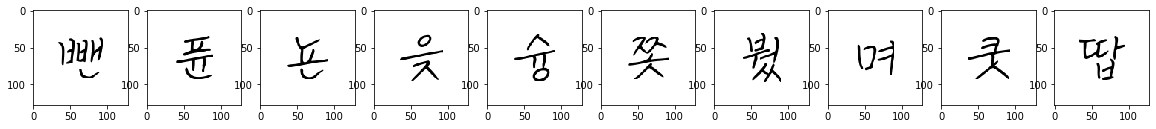

In [21]:
# anchor (이 이미지들을 Triplet network에 통과시켜 plotting할 것이다.)
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader[idx+5000][0][0], cmap='gray', label=idx)
plt.show()

---
## Make Latent Vectors

In [22]:
dset[1273]

({'font_doc2vec': [2.2403063999999997,
   -1.4756056999999998,
   -0.593018,
   -0.18605323,
   -1.2381212,
   -1.161201,
   2.8255024,
   0.10454782,
   -0.16260550000000001,
   1.2440913999999998],
  'font_index': 0,
  'word_index': 2143},
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [23]:
triplet_loader[0]

((array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]])),
 {'anchor_index': 1273, 'anchor_label': 0})

In [24]:
print(dset[0][1].shape)
print(triplet_loader[0][0][0].shape)

(128, 128)
(128, 128)


# K-means clustering
메모리상의 문제로 50000개만 테스트

In [0]:
import pandas as pd
from sklearn.cluster import KMeans

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

idxs = list(range(len(triplet_loader)))
np.random.shuffle(idxs)
batch_size = 32

sampler = SubsetRandomSampler(idxs) # 전체 샘플링
loader = torch.utils.data.DataLoader(
        triplet_loader,
        batch_size = batch_size,
        sampler = sampler
    )

In [0]:
tnet.eval()
with torch.no_grad():
    anchors = []
    labels  = []
    indexes = []
    for idx, ((img1, img2, img3), info) in enumerate(loader): 
        if device == 'cuda':
            img1, img2, img3 = img1.cuda(), img2.cuda(), img3.cuda()
        img1, img2, img3 = img1.float(), img2.float(), img3.float()

        _, _, anchor, _, _ = tnet(img1, img2, img3)
        anchors.append(anchor) 
        labels.append(info['anchor_label'])
        indexes.append(info['anchor_index'])
        if idx == 1000:
            break

In [30]:
len(anchors), len(labels), len(indexes)

(1001, 1001, 1001)

In [31]:
anchors[0].shape

torch.Size([32, 128, 1, 1])

In [32]:
latent = np.zeros((1, 128, 1, 1))
for i in range(len(anchors)):
    latent = np.concatenate([latent, anchors[i].cpu()])
latent = latent[1:]
print('latent shape: {}'.format(latent.shape))

tmp_label = np.zeros((1))
for i in range(len(labels)):
    tmp_label = np.concatenate([tmp_label, labels[i].cpu()])
tmp_label = tmp_label[1:]
print('label shape: {}'.format(tmp_label.shape))

tmp_index = np.zeros((1))
for i in range(len(indexes)):
    tmp_index = np.concatenate([tmp_index, indexes[i].cpu()])
tmp_index = tmp_index[1:]
print('index shape: {}'.format(tmp_index.shape))

latent shape: (32032, 128, 1, 1)
label shape: (32032,)
index shape: (32032,)


In [33]:
tmp_label[0], tmp_index[0] # dset[116740]과 대응

(56.0, 136870.0)

In [34]:
latent = latent.reshape(32032,128)
latent.shape

(32032, 128)

In [35]:
latent[0], tmp_index[0]

(array([ 0.09998119, -0.23477261,  0.0284244 , -0.04939822,  0.05614762,
        -0.08159187, -0.07194305,  0.02998504,  0.06461191,  0.06553785,
        -0.04296161, -0.0820726 , -0.06225835,  0.09571861, -0.04297545,
         0.04530541,  0.0519364 , -0.03115962, -0.00736579,  0.0795498 ,
        -0.07766343,  0.06100911, -0.0443666 ,  0.02238349,  0.03598484,
         0.05194227,  0.07002579,  0.04455588,  0.12528896, -0.07289457,
         0.05872232,  0.07927836, -0.03075837,  0.03951452,  0.03508534,
        -0.10058144, -0.07055721,  0.02602098,  0.03485351, -0.02826598,
         0.0218322 ,  0.04194805,  0.04754282, -0.03062513,  0.0354114 ,
         0.02249434, -0.01455066,  0.00645548, -0.04824299,  0.012326  ,
        -0.03009254,  0.07248993, -0.01899367, -0.09518386,  0.02427388,
        -0.0293817 ,  0.00151176, -0.05130066,  0.04127216, -0.06465775,
         0.02766302, -0.00227006, -0.05456667, -0.04986493,  0.07029536,
         0.00801632, -0.04146087, -0.13539861,  0.0

In [0]:
model = KMeans(n_clusters=4)
model.fit(latent)

y_predict = model.fit_predict(latent)

In [74]:
print(y_predict[:100])

[3 0 1 2 1 1 0 0 0 1 1 3 0 1 1 3 3 3 1 0 1 0 0 0 0 1 1 3 3 0 3 2 3 2 1 1 2
 1 3 3 3 0 0 1 0 2 1 0 0 2 1 1 0 1 0 0 0 3 3 3 0 2 1 0 3 1 0 3 3 2 2 1 1 0
 2 1 1 3 2 1 1 3 1 1 0 1 0 1 1 1 0 0 2 3 1 2 1 0 0 1]


In [0]:
colors = {0:'red', 1:'blue', 2: 'yellow', 3: 'pink'} #, 4:'green'}

In [76]:
[np.sum(y_predict==i) for i in range(4)]

[10714, 10660, 3619, 7039]

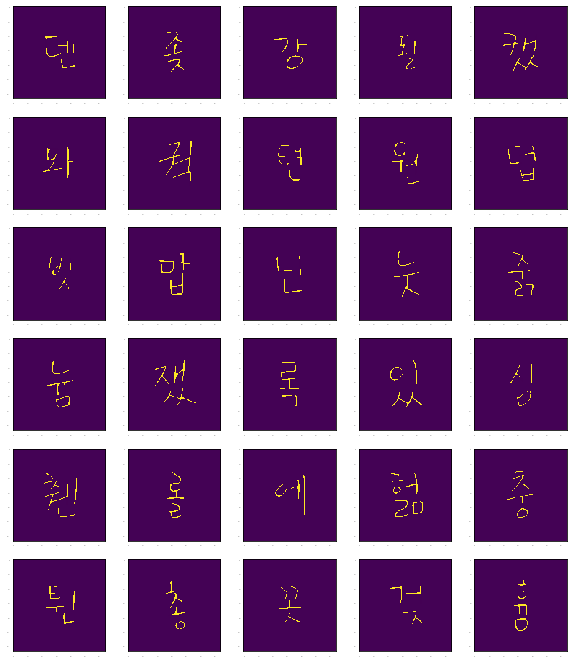

In [77]:
plt.figure(figsize=(10, 20))
s = 0
for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c==0:
        # print(idx)
        plt.subplot(10,5,s+1)
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
    if i == 100:
        break
        # for j in range(int(idx)):
        #     plt.subplot(17, 9, 9*s + j+1)
        #     plt.imshow(dset[i])
        #     plt.tick_params(axis='both', labelsize=0, length = 0)
#         plt.subplot(17, 9, 9*s + 9)
#         plt.plot(np.arange(10), color=colors[c])
#         plt.tick_params(axis='both', labelsize=0, length = 0)
        # s += 1
plt.show()
plt.close()

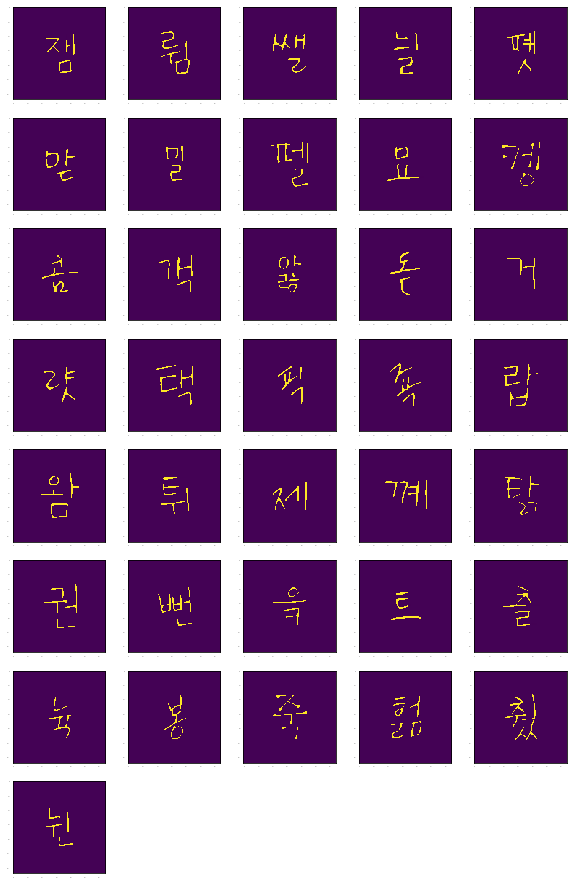

In [78]:
plt.figure(figsize=(10, 20))
s = 0
for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c==1:
        # print(idx)
        plt.subplot(10,5,s+1)
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
    if i == 100:
        break
        # for j in range(int(idx)):
        #     plt.subplot(17, 9, 9*s + j+1)
        #     plt.imshow(dset[i])
        #     plt.tick_params(axis='both', labelsize=0, length = 0)
#         plt.subplot(17, 9, 9*s + 9)
#         plt.plot(np.arange(10), color=colors[c])
#         plt.tick_params(axis='both', labelsize=0, length = 0)
        # s += 1
plt.show()
plt.close()

17459.0
160947.0
247972.0
217974.0
133268.0
192389.0
192061.0
133752.0
43461.0
49310.0
133792.0
43995.0
123634.0


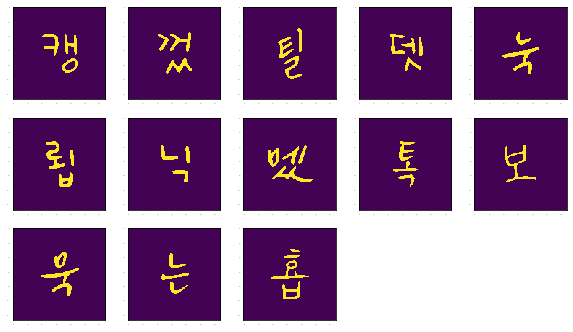

In [79]:
plt.figure(figsize=(10, 20))
s = 0
for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c==2:
        print(idx)
        plt.subplot(10,5,s+1)
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
    if i == 100:
        break
        # for j in range(int(idx)):
        #     plt.subplot(17, 9, 9*s + j+1)
        #     plt.imshow(dset[i])
        #     plt.tick_params(axis='both', labelsize=0, length = 0)
#         plt.subplot(17, 9, 9*s + 9)
#         plt.plot(np.arange(10), color=colors[c])
#         plt.tick_params(axis='both', labelsize=0, length = 0)
        # s += 1
plt.show()
plt.close()

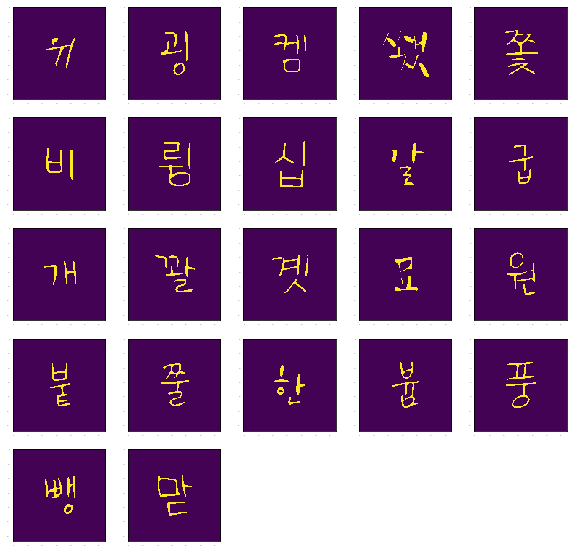

In [82]:
plt.figure(figsize=(10, 20))
s = 0
for i, (idx, c) in enumerate(zip(tmp_index, y_predict)): 
    if c==3:
        # print(idx)
        plt.subplot(10,5,s+1)
        image = dset[int(idx)][1].astype('uint8')
        plt.imshow(image)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        s += 1
    if i == 100:
        break
        # for j in range(int(idx)):
        #     plt.subplot(17, 9, 9*s + j+1)
        #     plt.imshow(dset[i])
        #     plt.tick_params(axis='both', labelsize=0, length = 0)
#         plt.subplot(17, 9, 9*s + 9)
#         plt.plot(np.arange(10), color=colors[c])
#         plt.tick_params(axis='both', labelsize=0, length = 0)
        # s += 1
plt.show()
plt.close()